In [ ]:
! pip install wandb
! pip3 install wandb
! pip install torch torchvision torchaudio numpy

Make sure to authenticate your local development environment by running the command ```wandb login```, which will prompt you to paste your API key.

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from torch import nn
import wandb

# Initialize W&B
wandb.init(project="fashion-mnist")

# Assuming CPU usage
device = "cpu"

# Check for CUDA GPU availability
if torch.cuda.is_available():
    device = "cuda"
# If CUDA is not available, check for MPS availability (Apple silicon)
elif torch.backends.mps.is_available():
    device = "mps"

print(f"Using {device} device")

fashion_mnist_training = datasets.FashionMNIST(
    root="data/FashionMNIST",
    train=True,
    download=True,
    transform=ToTensor(),
)

fashion_mnist_test = datasets.FashionMNIST(
    root="data/FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor(),
)

/Users/richmondalake/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/Users/richmondalake/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: richmondnet. Use `wandb login --relogin` to force relogin


Using cpu device


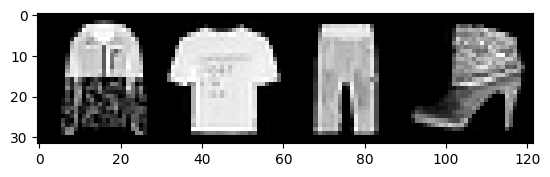

Labels:   Coat T-shirt/top Trouser Ankle boot


In [3]:
import matplotlib.pyplot as plt

# FashionMNIST class names
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def imshow(img):
    # Convert the tensor image to numpy for displaying
    img = img.numpy()
    # The images are in Channel x Height x Width format. Convert them to Height x Width x Channel format.
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Get some random training images
data_loader = torch.utils.data.DataLoader(fashion_mnist_training, batch_size=4, shuffle=True)
images, labels = next(iter(data_loader))

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [4]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(fashion_mnist_training))
validation_size = len(fashion_mnist_training) - train_size
train_dataset, validation_dataset = random_split(fashion_mnist_training, [train_size, validation_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 784),
            nn.ReLU(),
            nn.Linear(784, 784),
            nn.ReLU(),
            nn.Linear(784, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
from torch import optim

# Initialize the neural network
model_fashion = NeuralNetwork(28*28, 10).to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fashion.parameters())

In [7]:
# Training function
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # Log training metrics to W&B
            wandb.log({"epoch": epoch, "batch_loss": loss, "batch": batch})



In [8]:
# Validation function
def validate(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= num_batches
    correct /= size
    print(f"Validation Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")
    # Log validation metrics to W&B
    wandb.log({"epoch": epoch, "validation_loss": validation_loss, "validation_accuracy": correct})


In [9]:
# Training loop
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model_fashion, loss_fn, optimizer, epoch)
    validate(validation_loader, model_fashion, loss_fn, epoch)
print("Training done!")

Epoch 1
-------------------------------
loss: 2.297832  [    0/48000]
loss: 0.487481  [ 6400/48000]
loss: 0.269279  [12800/48000]
loss: 0.302580  [19200/48000]
loss: 0.511297  [25600/48000]
loss: 0.359479  [32000/48000]
loss: 0.313266  [38400/48000]
loss: 0.431401  [44800/48000]
Validation Error: Accuracy: 83.9%, Avg loss: 0.438292 

Epoch 2
-------------------------------
loss: 0.536376  [    0/48000]
loss: 0.257389  [ 6400/48000]
loss: 0.730881  [12800/48000]
loss: 0.372094  [19200/48000]
loss: 0.382029  [25600/48000]
loss: 0.355762  [32000/48000]
loss: 0.450452  [38400/48000]
loss: 0.476491  [44800/48000]
Validation Error: Accuracy: 86.6%, Avg loss: 0.368948 

Epoch 3
-------------------------------
loss: 0.279517  [    0/48000]
loss: 0.416631  [ 6400/48000]
loss: 0.367672  [12800/48000]
loss: 0.309907  [19200/48000]
loss: 0.547899  [25600/48000]
loss: 0.251108  [32000/48000]
loss: 0.392729  [38400/48000]
loss: 0.159858  [44800/48000]
Validation Error: Accuracy: 87.7%, Avg loss: 0.3

In [10]:
# Test the model
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # Log test metrics to W&B
    wandb.log({"test_loss": test_loss, "test_accuracy": correct})


In [11]:
test(test_loader, model_fashion)

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.366266 



wandb: Network error (ConnectionError), entering retry loop.
